In [2]:

# LINK A COLAB NOTEBOOK: https://colab.research.google.com/drive/1fcMRaDTmeH4mAeNaaECNMRtMFQH7yM9t?usp=sharing

# Importazione delle librerie
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import CategoricalAccuracy
from keras.metrics import MeanSquaredError

# Caricamento del dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizza dati di train e test
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

# Iperparametri di training
epochs=6
available_epochs = [2,3,4,5,6,7,8,9,10]
batch_size=8
available_batch_sizes = [256, 128,64, 32,  16, 8] # il modello funziona molto meglio se il batch size è basso
loss_fun = "mse"
optimizer="adam"  #"sgd"#rmsp"
available_optimizers = ["adam", "nadam", "RMSprop"] # RMSprop funziona molto male
metrics_list = [MeanSquaredError(name="acc")]

# Definizione del generatore di immagini blurred
def generator(dataset, batchsize, moves=10):
    while True:
        rand = np.random.randint(dataset.shape[0], size=batchsize)
        y_truth = dataset[rand]
        blurred = np.copy(y_truth)
        moving = tf.expand_dims(y_truth, axis=-1)

        for i in range(moves):
            moving = layers.RandomTranslation(0.07, 0.07, fill_mode='constant', interpolation='bilinear')(moving)
            blurred = blurred + tf.squeeze(moving)
        blurred = blurred / (moves + 1)
        yield (blurred, y_truth)

# Creazione del generatore
train_gen = generator(x_train, batch_size)


11490434/11490434 [==============================] - 0s 0us/step


# Struttura della rete
Ho deciso di utilizzare un approccio convoluzionale per costruire la mia rete in quanto riesce ad adattarsi particolarmente bene al problema di deblur di immagini.

Le CNN sono progettate per catturare pattern locali nelle immagini. Questo è particolarmente rilevante per problemi di deblurring, poiché spesso è necessario concentrarsi su piccole regioni dell'immagine per correggere gli effetti dello sfocato.

Dopo vari test, la seguente struttura è riuscita a performare bene sul problema

In [4]:
# Definizione del modello per il deblurring
def build_conv_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv4 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv3)
    model = Model(inputs, conv4)
    return model


In [5]:

# Crea nome della cartella in base agli iperparametri dove salvare grafici e risultati
def create_folder_name():
    folder_name = f"epochs_{epochs}_batch_size_{batch_size}_loss_fun_{loss_fun}_optimizer_{optimizer}"
    # Create folder if not exists
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

# Funzione per visualizzare le immagini
def plot(x, y, name = 'example'):
    no = x.shape[0]
    print(no)
    plt.figure(figsize=(2*no, 4))
    for i in range(no):
        ax = plt.subplot(2, no, i + 1)
        plt.imshow(x[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, no, i + 1 + no)
        plt.imshow(y[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig(f"{create_folder_name()}/{name}.png")


# Plotta l'andamento del training e della validation
def plot_results(train_history, num_epochs, test_results):

    # Estrai la loss di training e validation
    training_loss = train_history.history['loss']

    # Estrai le metriche di training e validation
    training_metrics = train_history.history['acc']

    # Crea un grafico
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, test_results, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()


    plt.tight_layout()
    plt.savefig(f"{create_folder_name()}/plot.png")


In [6]:
# Train del modello
def train_model():

    input_shape = x_train.shape[1:] + (1,)

    # Calcola steps per epoch
    steps_per_epoch = x_train.shape[0] // batch_size

    # Stampa un riassunto degli iperparametri
    print(f"epochs: {epochs}")
    print(f"batch_size: {batch_size}")
    print(f"optimizer: {optimizer}")

    # Build, compile and fit
    deblur_model_conv = build_conv_model(input_shape)
    deblur_model_conv.compile(optimizer=optimizer, loss=loss_fun, metrics=metrics_list)
    history = deblur_model_conv.fit(train_gen, epochs=epochs, batch_size=batch_size, steps_per_epoch = steps_per_epoch)

    # Salva storia training come array numpy
    np.save(create_folder_name() + "/history.npy", history.history)

    # Save model
    deblur_model_conv.save(create_folder_name() + "/deblur_model_conv.keras")

    return deblur_model_conv

deblur_model_conv = train_model()

epochs: 6
batch_size: 8
optimizer: adam
Epoch 1/6
7500/7500 [==============================] - 964s 128ms/step - loss: 0.0291 - acc: 0.0291
Epoch 2/6
7500/7500 [==============================] - 954s 127ms/step - loss: 0.0164 - acc: 0.0164
Epoch 3/6
7500/7500 [==============================] - 961s 128ms/step - loss: 0.0141 - acc: 0.0141
Epoch 4/6
7500/7500 [==============================] - 959s 128ms/step - loss: 0.0129 - acc: 0.0129
Epoch 5/6
7500/7500 [==============================] - 955s 127ms/step - loss: 0.0123 - acc: 0.0123
Epoch 6/6
7500/7500 [==============================] - 966s 129ms/step - loss: 0.0118 - acc: 0.0118


313/313 [==============================] - 1s 2ms/step
20
313/313 [==============================] - 1s 2ms/step
20
313/313 [==============================] - 1s 2ms/step
20
313/313 [==============================] - 1s 3ms/step
20
313/313 [==============================] - 1s 2ms/step
20
313/313 [==============================] - 1s 2ms/step
20
313/313 [==============================] - 1s 2ms/step
20
313/313 [==============================] - 1s 2ms/step
20
313/313 [==============================] - 1s 3ms/step
20
313/313 [==============================] - 1s 2ms/step
20
MSE values: [0.011663914, 0.011381649, 0.011558794, 0.011376524, 0.011559609, 0.01149638, 0.011612803, 0.011487666, 0.011675002, 0.011428675]
Mean MSE over 10 rounds: 0.011524101719260216
Standard Deviation of MSE over 10 rounds: 0.0001029197228490375


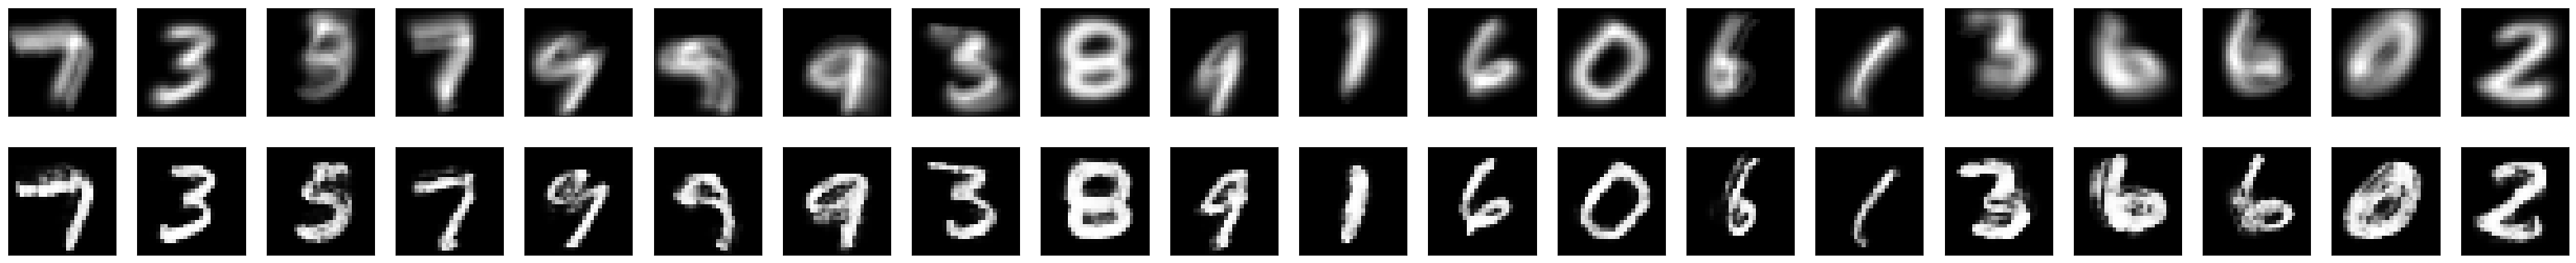

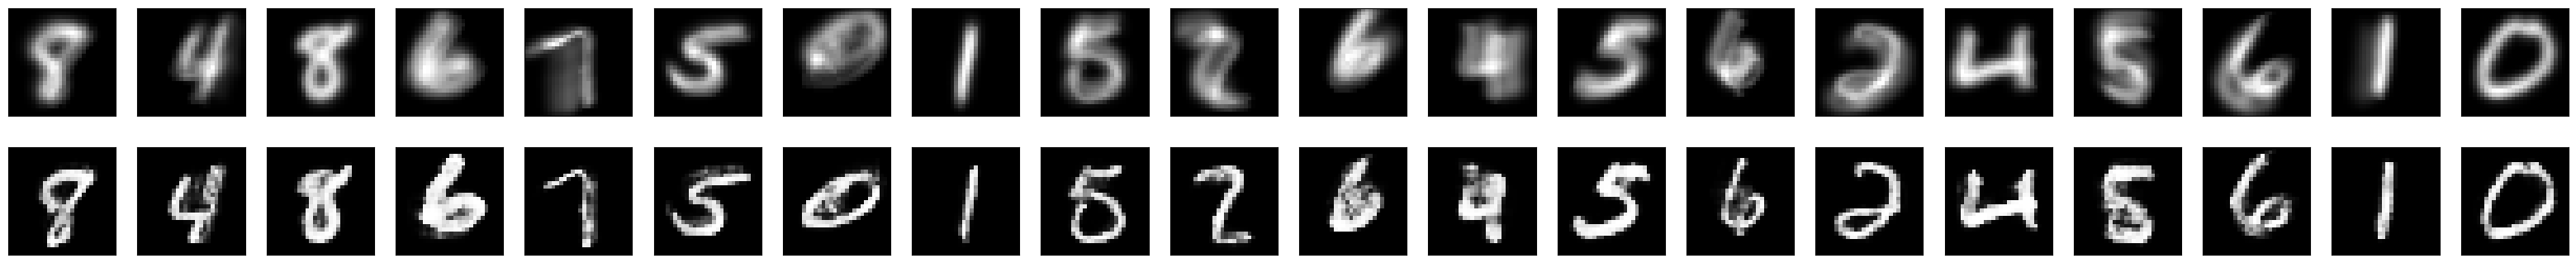

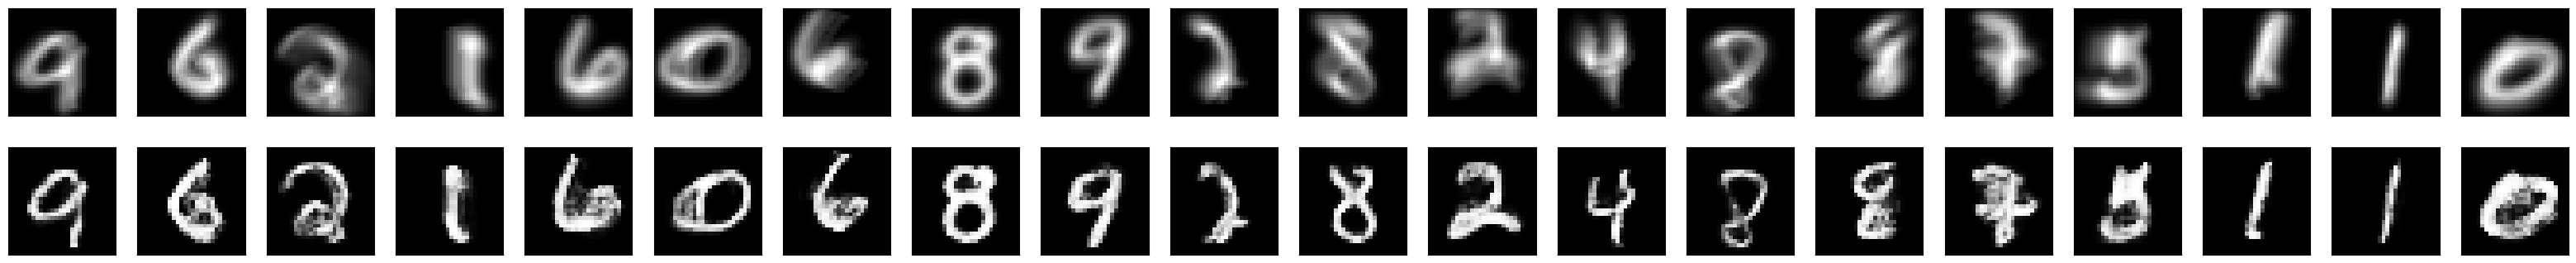

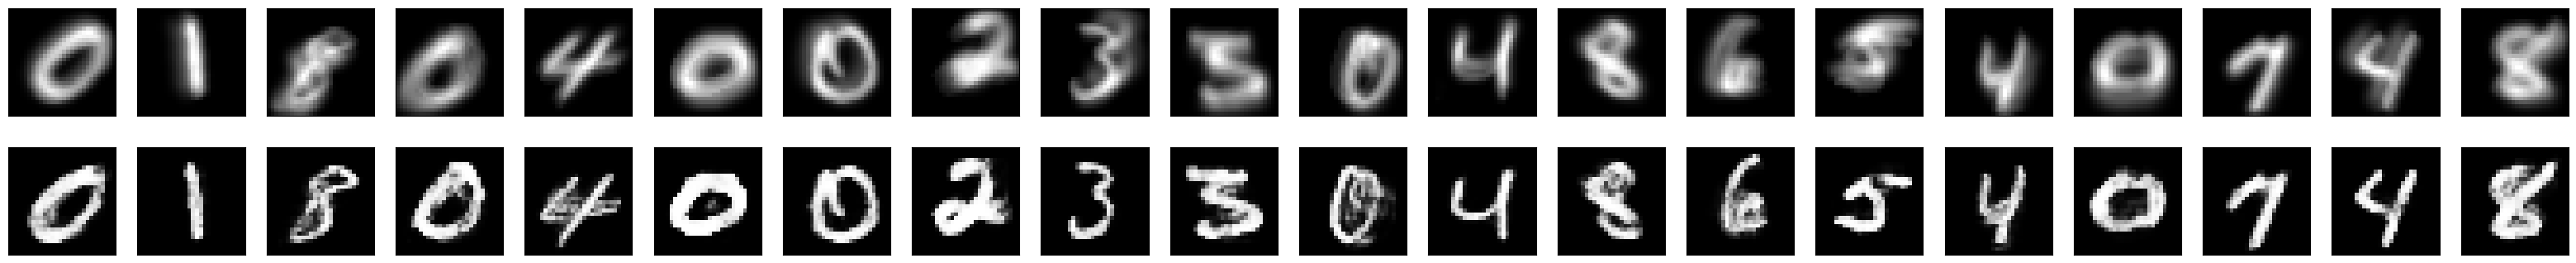

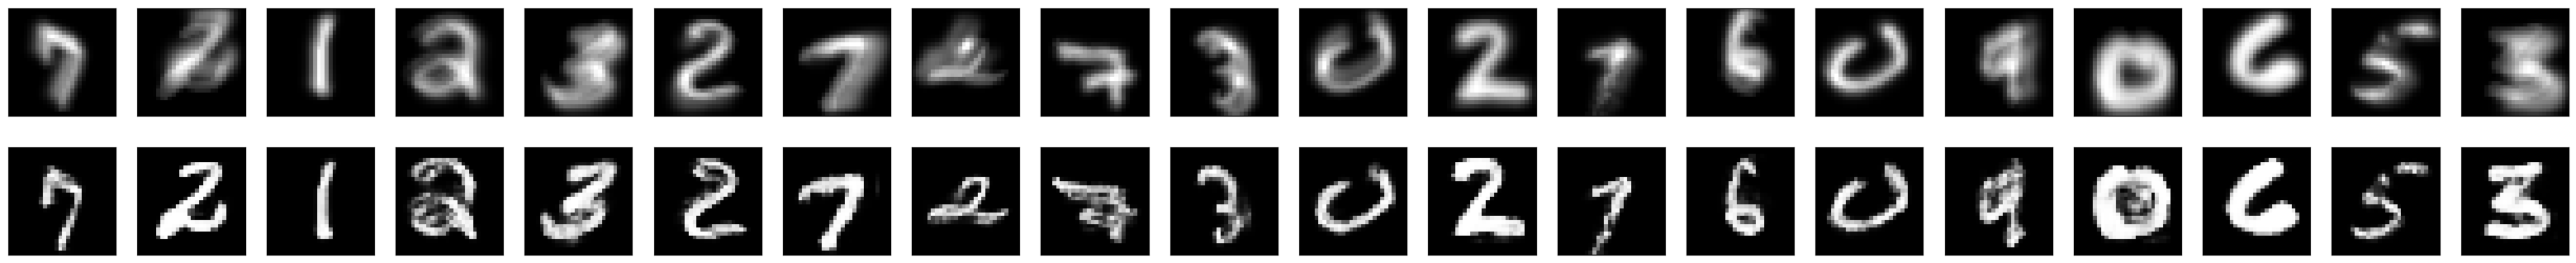

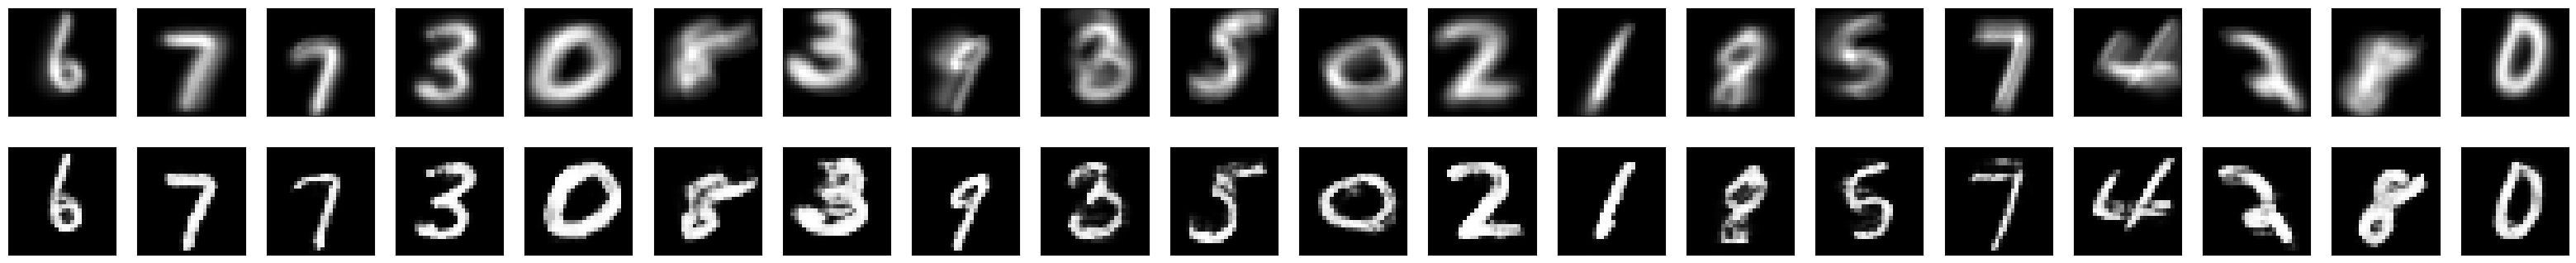

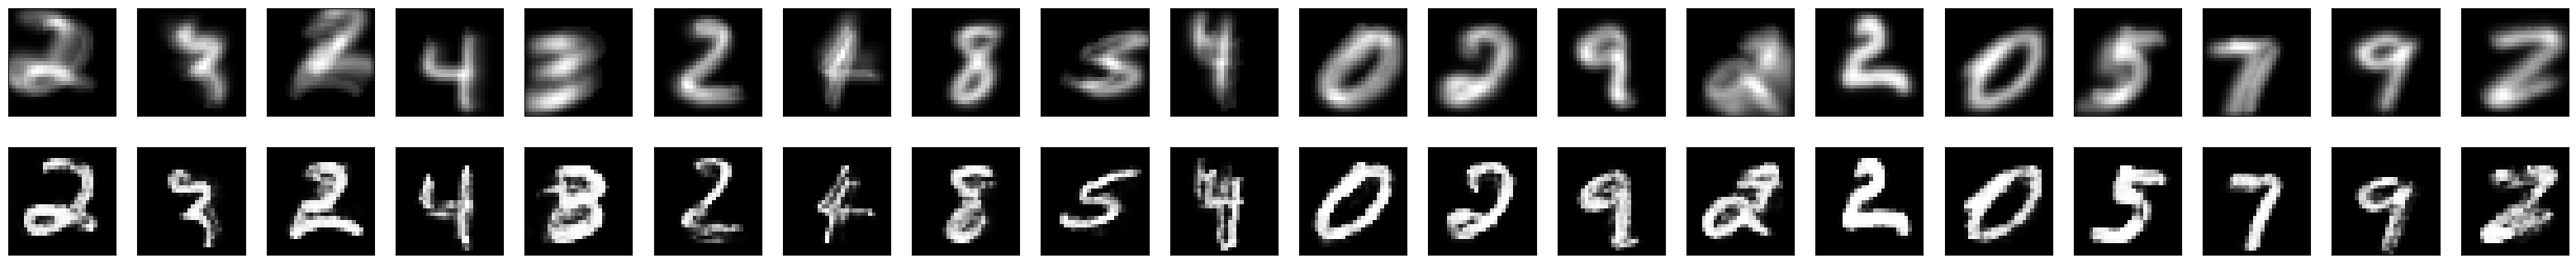

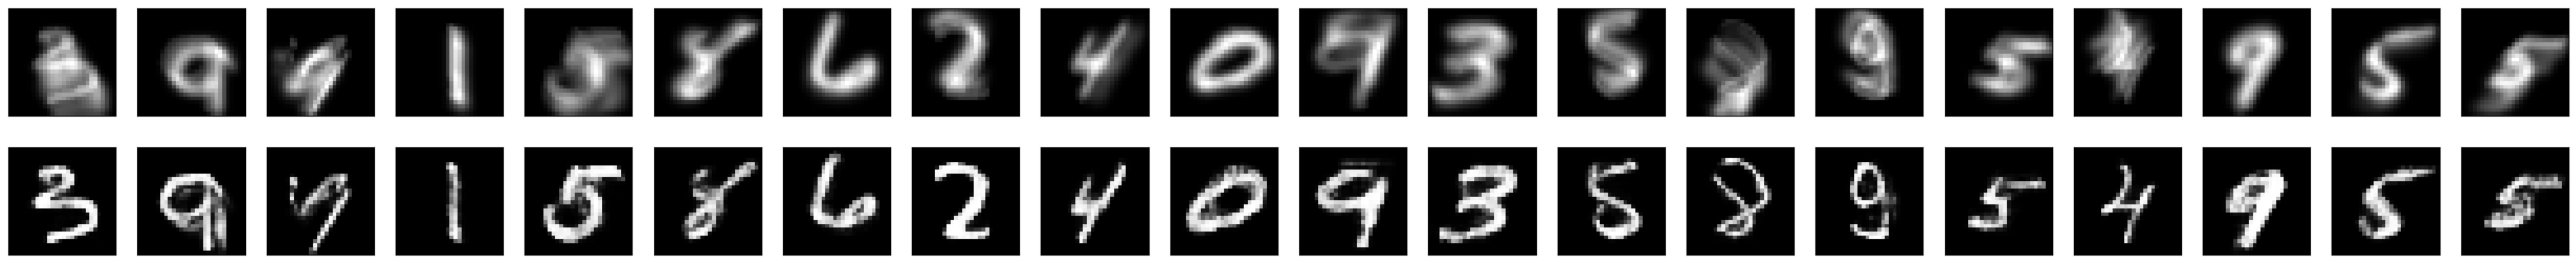

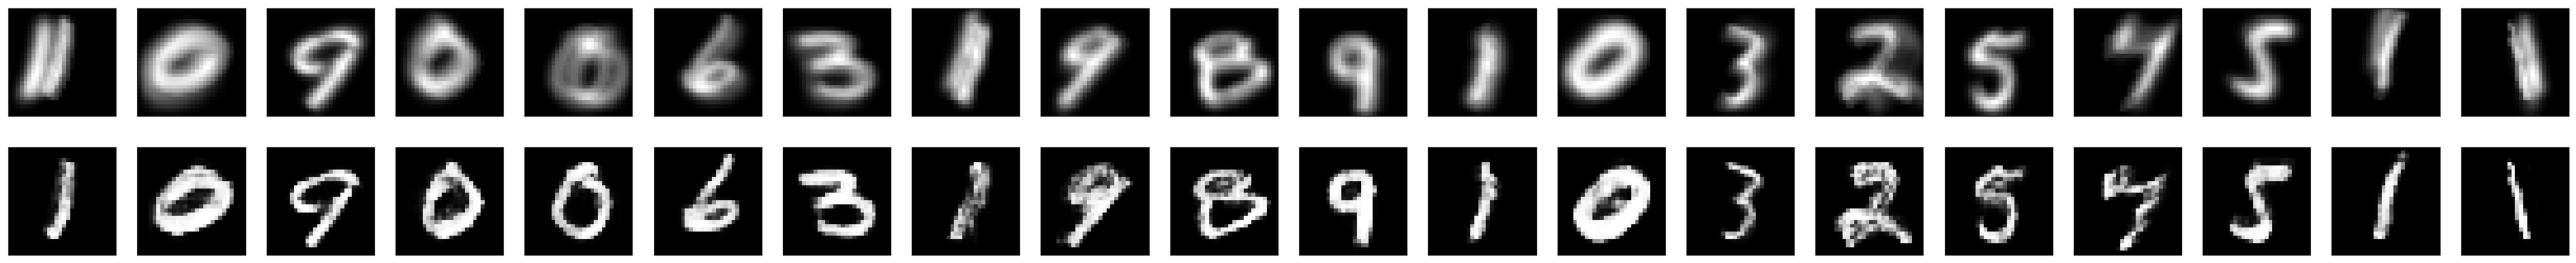

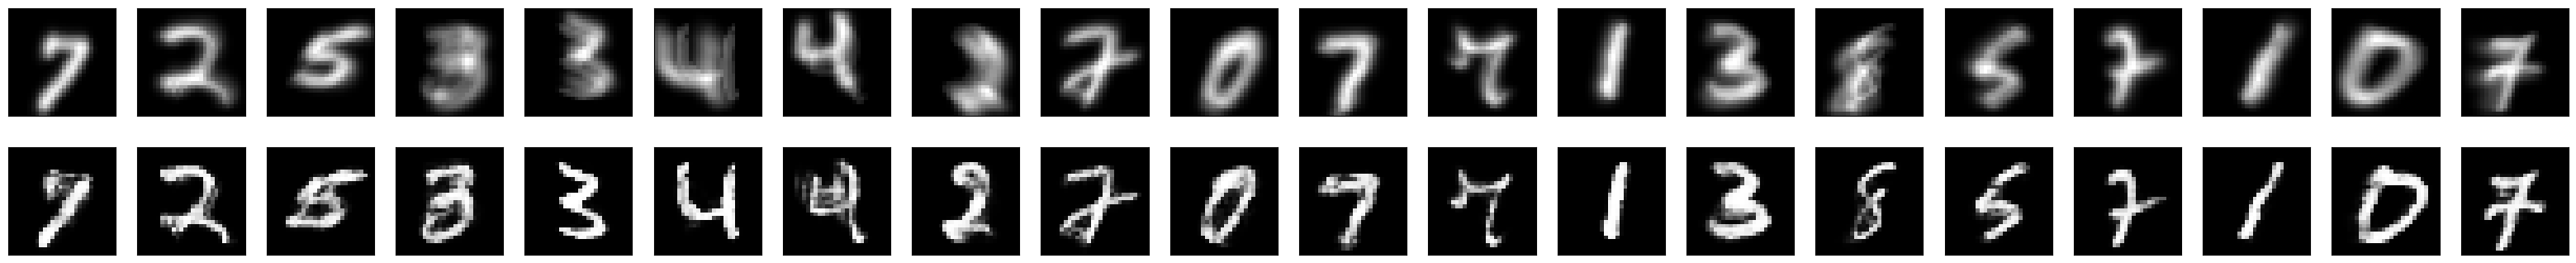

In [7]:
def test_model():

  # Valutazione del modello sul validation set
  mse_values = []
  for i in range(10):

      blurred_images, ground_truth = next(generator(x_test, batchsize=10000))
      deblurred_images = deblur_model_conv.predict(blurred_images).squeeze()

      # Salva degli esempi di risultati ottenuti
      plot(blurred_images[0:20], deblurred_images[0:20], name=f"example_{i}")

      # Calcola mse e salva
      mse = np.mean((deblurred_images - ground_truth)**2)
      mse_values.append(mse)


  # Calcolo media e deviazione standard delle MSE
  mean_mse = np.mean(mse_values)
  std_mse = np.std(mse_values)

  # Plot results
  #plot_results(history, epochs, mse_values)

  # Stampa risultati ottenuti
  print(f"MSE values: {mse_values}")
  print(f"Mean MSE over 10 rounds: {mean_mse}")
  print(f"Standard Deviation of MSE over 10 rounds: {std_mse}")

  # Salva risultati su file
  file = open(f"{create_folder_name()}/results.txt", "w")
  file.write(f"epochs: {epochs}\n")
  file.write(f"batch_size: {batch_size}\n")
  file.write(f"optimizer: {optimizer}\n")

  file.write(f"Mean MSE over 10 rounds: {mean_mse}\n")
  file.write(f"Standard Deviation of MSE over 10 rounds: {std_mse}\n")
  file.close()

test_model()

# Come ho ottenuto gli iperparametri ottimali
Mediante i seguenti cicli annidati, ho fatto partire il training del modello esplorando più combinazioni di iperparametri.
In un secondo momento, ho potuto analizzare i risultati prodotti dalle diverse esecuzioni avendo salvato grafici, modello e dati su disco.

Queste sono state le osservazioni:
- La prima cosa che ho potuto notare è stata che i modelli con un batch size basso, nonostante alzassero i tempi di training enormemente, erano quelli che fornivano risultati più decisamente piú accurati.
- La seconda cosa che ho potuto notare é che dopo le 4/5 epoche, il training non migliorava di molto, anzi, controllando i risultati prodotti sembrava che stessero peggiorando invece di migliorare
  - Questo é stato causato molto probabilmente da un overfitting del modello ai dati di train
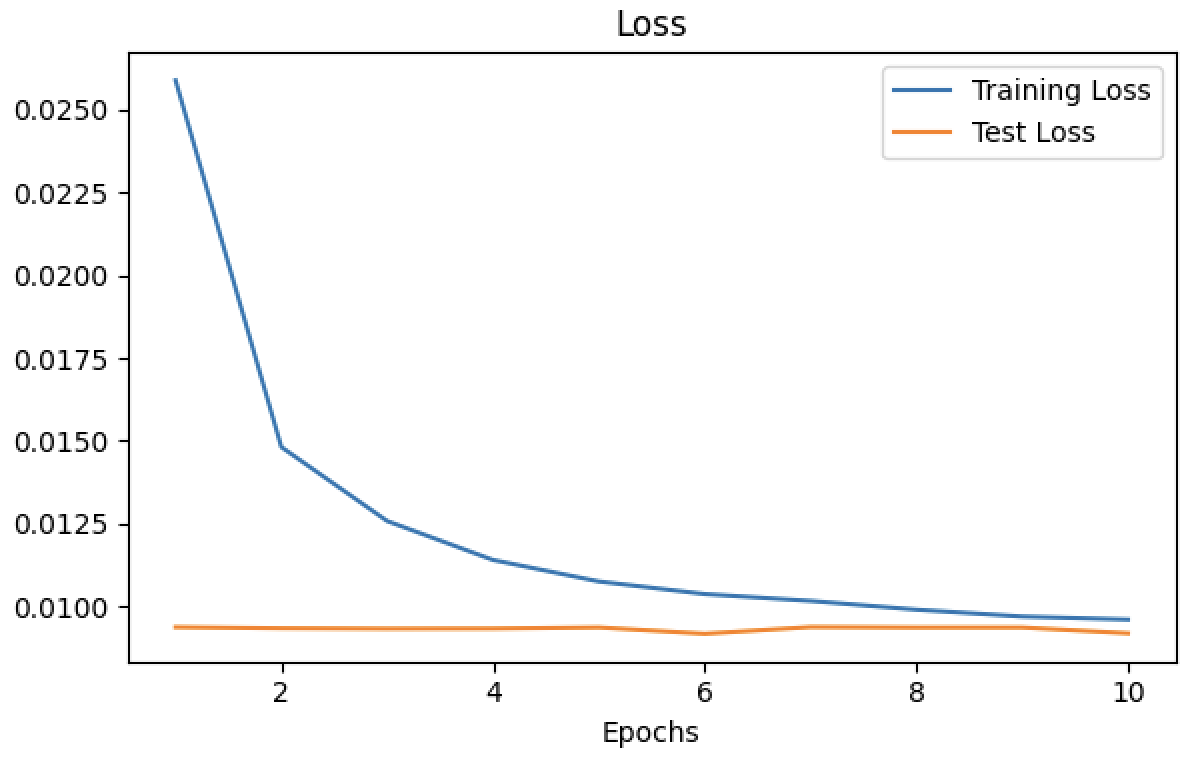

Ho deciso quindi di utilizzare 6 epoche come valore definitivo

Risultato ottenuto con training a 10 epoche
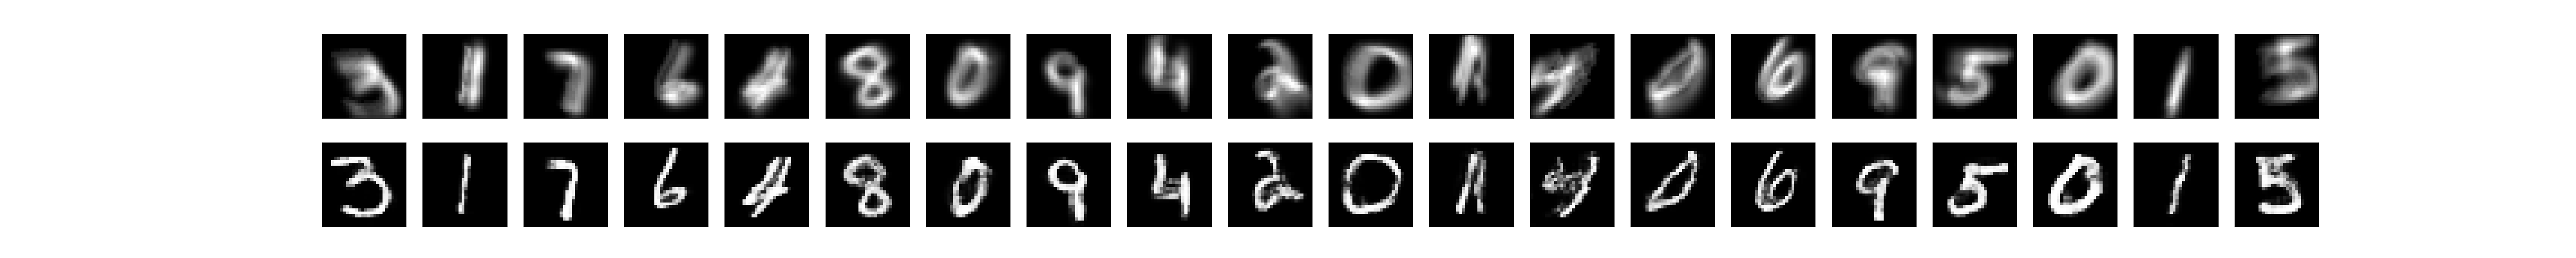

Risultato ottenuto con 6 epoche
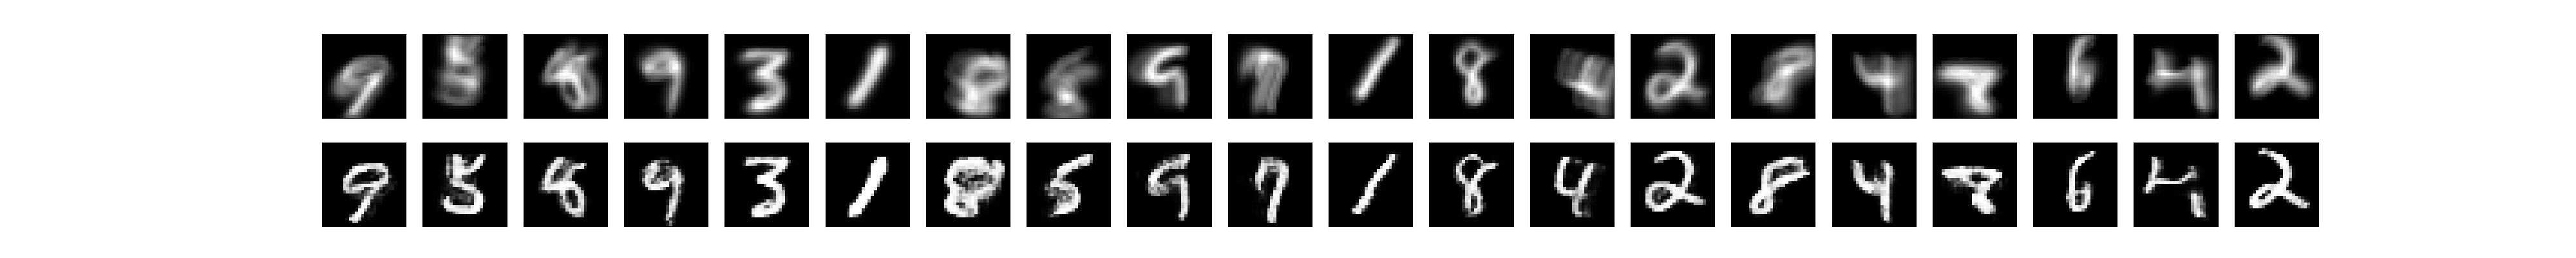

In [ ]:
# 1. epochs
for epochs_cur in available_epochs:

    epochs = epochs_cur
    validation_iterations = epochs

    # 2. batch_size
    for batch_size_cur in available_batch_sizes:

        batch_size = batch_size_cur

        # 3. optimizer
        for optimizer_cur in available_optimizers:
            train_model();